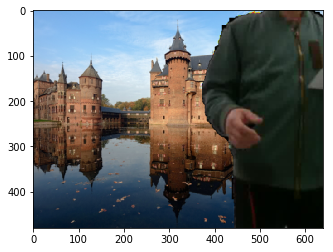

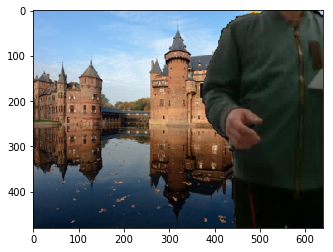

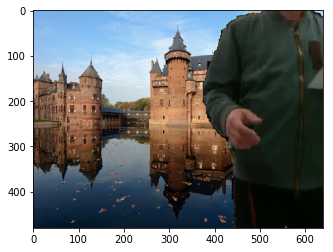

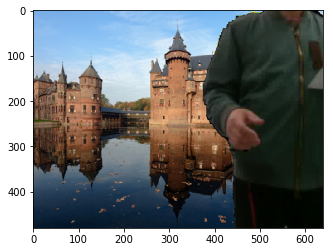

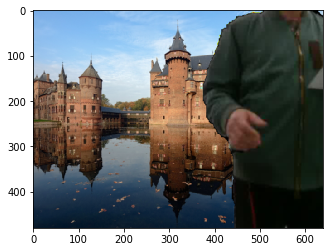

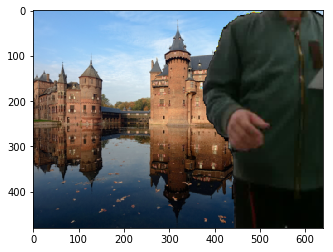

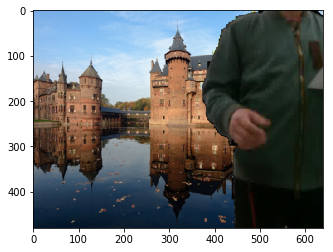

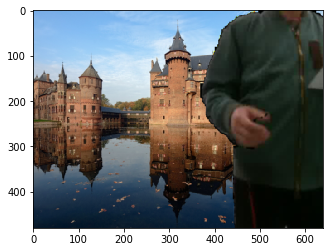

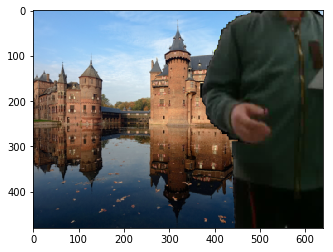

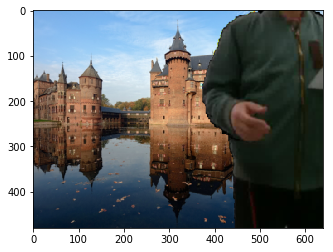

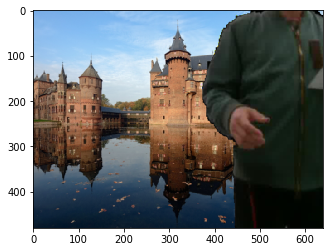

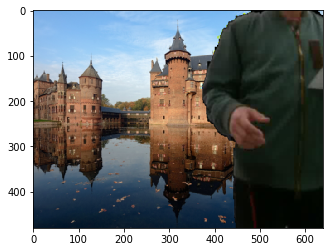

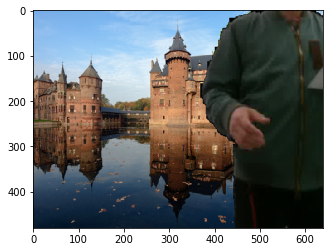

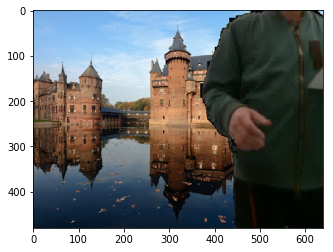

KeyboardInterrupt: 

In [10]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt 
import scipy.misc
import cv2
import copy
import time

# data path 
depth_data_path = "/mnt/data/jarvislam1999/data/subject01_depth/rgb/"
background_data_path = "/mnt/data/jarvislam1999/data/subject01_bg/"
foreground_data_path = "/mnt/data/jarvislam1999/data/subject01_nobg/rgb/"

# store path
added_bg_data_path = "/mnt/data/jarvislam1999/data/tmp"

#start_time = time.time()

# get all subdirectories that contain images (frames)
#background_data_subdirt = os.listdir(background_data_path)
depth_data_subdirt = [r[0] for r in os.walk(depth_data_path)]
background_data_subdirt = [r[0] for r in os.walk(background_data_path)]
foreground_data_subdirt = [r[0] for r in os.walk(foreground_data_path)]
depth_data_subdirt.sort()
foreground_data_subdirt.sort()

background_data_subdirt = background_data_subdirt[1:]
background_data_subdirt.sort()
foreground_data_subdirt = foreground_data_subdirt[1:]
fg_frames = os.listdir(foreground_data_subdirt[0])
fg_frames.sort()
depth_data_subdirt = foreground_data_subdirt[0].replace(foreground_data_path + '/', depth_data_path)
depth_frames = depth_data_subdirt + '/' + fg_frames[0]
#print("--- Finding and sorting dir: %s seconds ---" % (time.time() - start_time))
iter_bg = 4
# loop through all subdirts (a subdirt contains the frames of one gesture)
for subdirt_bg in background_data_subdirt:
    #if (iter_bg == 1):
    #    break
    #if (iter_bg != 5):
    #    iter_bg += 1
    #    continue
    iter_bg += 1
    bg_frames = os.listdir(subdirt_bg)
    bg_frames.sort()
    
    iter_fg = 0
    for subdirt_fg in foreground_data_subdirt:
        #start_time = time.time()
        
        #if (iter_fg == 2):
        #    break
        #iter_fg += 1
        #print(subdirt_fg)
        #if (iter_fg <= 340):
        #    iter_fg += 1
        #    continue
        iter_fg += 1
        subdirt_depth = subdirt_fg.replace(foreground_data_path + '/', depth_data_path)
        #print(subdirt_depth)
        if not os.path.isdir(subdirt_depth):
            #print('Wop')
            continue
        
        fg_frames = os.listdir(subdirt_fg)
        fg_frames.sort()
        #print(fg_frames)
        
        # Making sure that the bkg and frg frames match in length
        if (len(bg_frames) == 1):
            bg_frames *= len(fg_frames)
        if (len(bg_frames) < len(fg_frames)):
            bg_frames += [bg_frames[len(bg_frames) - 1] * (len(fg_frames) - len(bg_frames))]
        if (len(bg_frames) > len(fg_frames)):
            bg_frames = bg_frames[0:len(fg_frames)]
        
        frames = []
        for i in range(0, len(fg_frames)):
            frames.append([bg_frames[i], fg_frames[i]])
        
        #print("--- Preparing frames: %s seconds ---" % (time.time() - start_time))
        
        # loop through each frame in a gesture
        for frame in frames:
            # load the pixels of a background image (a frame)
            bg_path = subdirt_bg+'/'+frame[0]
            bg_img = Image.open(bg_path, 'r')
            pixels_of_bg_img = np.array(bg_img.getdata())
            pixels_of_bg_img = np.reshape(pixels_of_bg_img, (480, 640, 3))
            pixels_bg_img = copy.deepcopy(pixels_of_bg_img)
            #plt.imshow(pixels_of_bg_img, interpolation="none")
            #plt.show()
        
            # load the pixels of an foreground image (a frame)
            fg_path = subdirt_fg+'/'+frame[1]
        
            fg_img = Image.open(fg_path, 'r')
            pixels_of_fg_img = np.array(fg_img.getdata())
            pixels_of_fg_img = np.reshape(pixels_of_fg_img, (480, 640, 3))
            #plt.imshow(pixels_of_fg_img, interpolation="none")
            #plt.show()
            
            # load the pixels of a depth image ( a frame)
            depth_path = subdirt_depth + '/' + frame[1]
            if not os.path.isfile(depth_path):
                continue
            
            depth_img = Image.open(depth_path, 'r')
            pixels_of_depth_img = np.array(depth_img.getdata())
            pixels_of_depth_img = np.reshape(pixels_of_depth_img, (480, 640, 3))
            #plt.imshow(pixels_of_depth_img, interpolation="none")
            #plt.show()
            
            #temp_matrix_1 = (pixels_of_fg_img==[0, 0, 0])
            #temp_matrix_1 = np.greater([2,2,2], pixels_of_fg_img)
            #temp_matrix_1 = np.logical_and(np.greater([105,105,105], pixels_of_depth_img), \
            #                              np.greater([1,1,1], pixels_of_fg_img))
            temp_matrix_1 = np.logical_and(np.greater([50,50,50], pixels_of_depth_img), \
                                           pixels_of_fg_img==[0, 0, 0])
            
            # Applying shade removal code
            temp_matrix_1 = np.array(temp_matrix_1)
            temp_matrix_1 = np.logical_not(temp_matrix_1)
            kernel = np.ones((30,30), np.uint8)
            temp_matrix_1 = temp_matrix_1.astype('uint8')
            temp_matrix_1 = cv2.morphologyEx(temp_matrix_1, cv2.MORPH_OPEN, kernel)
            temp_matrix_1 = np.logical_not(temp_matrix_1)
            
            '''
            for row in range(len(temp_matrix_1)-1):
                for col in range(len(temp_matrix_1[row]) -1 ):
                    if (not all(temp_matrix_1[row][col])):
                        temp_matrix_1[row][col] = [False, False, False]
            '''
            # Making all r,g,b channel agree
            temp_matrix_r = np.logical_and(temp_matrix_1[:,:,0], temp_matrix_1[:,:,1])
            temp_matrix_r = np.logical_and(temp_matrix_r, temp_matrix_1[:,:,2])
            temp_matrix_1[:,:,0] = temp_matrix_r
            temp_matrix_1[:,:,1] = temp_matrix_r
            temp_matrix_1[:,:,2] = temp_matrix_r
            #print(temp_matrix_1)
            
            # Taking out background
            pixels_of_bg_img = pixels_of_bg_img * temp_matrix_1
            #plt.imshow(pixels_of_bg_img, interpolation="none")
            #plt.show()
            
            pixels_added_bg_img = pixels_of_bg_img + pixels_of_fg_img
            pixels_added_bg_img = np.array(pixels_added_bg_img, dtype=np.uint8)
            #plt.imshow(pixels_added_bg_img, interpolation="none")
            #plt.show()
            '''
            r=2
            for row in range(len(pixels_added_bg_img)-1, -1, -1):
                for col in range(len(pixels_added_bg_img[row])-1, -1, -1):                      
                    if (all(np.greater([5,5,5], pixels_added_bg_img[row][col]))):
                        #print(pixels_bg_img[row][col])
                        #pixels_added_bg_img[row][col] = pixels_bg_img[row][col]
           
                        for i in range(max(0, row - r), min(row+r, len(pixels_added_bg_img))):
                            for j in range(max(0, col-r), min(col+r, len(pixels_added_bg_img[i]))):
                                if (all(pixels_added_bg_img[i][j] == pixels_bg_img[i][j])):
                                    pixels_added_bg_img[row][col] = pixels_bg_img[row][col]
                        
            '''
            
            pixels_added_bg_img = cv2.GaussianBlur(pixels_added_bg_img, (3,3), 0)
            plt.imshow(pixels_added_bg_img, interpolation="none")
            plt.show()
            
            added_bg_img = Image.fromarray(pixels_added_bg_img)
            
            
            if not os.path.isdir(added_bg_data_path+'subject01_bg'+ (str(iter_bg) if (iter_bg > 9) else '0'+str(iter_bg))):
                print("create new dir: " + added_bg_data_path+'subject01_bg'+ (str(iter_bg) if (iter_bg > 9) else '0'+str(iter_bg)))
                os.mkdir(added_bg_data_path+'subject01_bg'+ (str(iter_bg) if (iter_bg > 9) else '0'+str(iter_bg)))
                os.mkdir(added_bg_data_path+'subject01_bg'+ (str(iter_bg) if (iter_bg > 9) else '0'+str(iter_bg))+'/rgb/')
            if not os.path.isdir(added_bg_data_path+'subject01_bg'+ (str(iter_bg) if (iter_bg > 9) else '0'+str(iter_bg))+'/rgb/'+subdirt_fg.replace(foreground_data_path, "")):
                print("create new dir: " + added_bg_data_path+'subject01_bg'+ (str(iter_bg) if (iter_bg > 9) else '0'+str(iter_bg))+'/rgb/'+subdirt_fg.replace(foreground_data_path, ""))                 
                os.mkdir(added_bg_data_path+'subject01_bg'+ (str(iter_bg) if (iter_bg > 9) else '0'+str(iter_bg))+'/rgb/'+subdirt_fg.replace(foreground_data_path, ""))
            added_bg_img.save(added_bg_data_path+'subject01_bg'+ (str(iter_bg) if (iter_bg > 9) else '0'+str(iter_bg))+'/rgb/'+fg_path.replace(foreground_data_path, ""))


In [ ]:
background_data_subdirt.sort()

In [ ]:
background_data_subdirt